In [1]:
#!pip install Pymcubes
#!pip install trimesh

In [2]:
import mcubes
import trimesh

In [3]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_org import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [4]:
device = 'cuda'
tn = 8.
tf = 12.
#model = torch.load('model_nerf_21602', weights_only=False).to(device)
model = Nerf(hidden_dim=128).to(device)  # Use the same architecture as during training
state_dict = torch.load("./model_nerf_21602")
model.load_state_dict(state_dict)
model.eval()

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=129, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [5]:
N = 100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))

c:\Users\super\Documents\Github\sequoia\.venv\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
xyz = torch.cat((x.reshape(-1, 1),
                 y.reshape(-1, 1),
                 z.reshape(-1, 1)), dim=1)

In [7]:
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))
    
density = density.cpu().numpy().reshape(N, N, N)

Density Min: 0.0
Density Max: 93.71508026123047
Density Mean: 2.8136422634124756
Density Median: 0.0


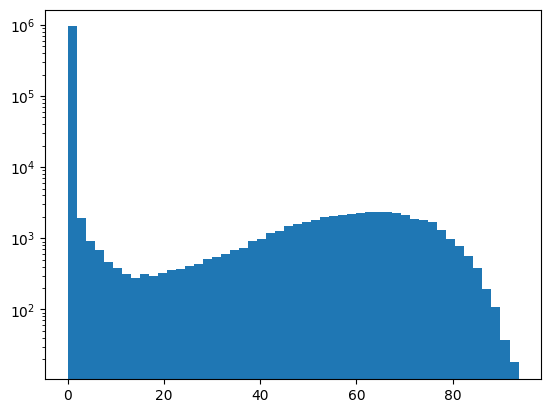

In [8]:
print(f"Density Min: {np.min(density)}")
print(f"Density Max: {np.max(density)}")
print(f"Density Mean: {np.mean(density)}")
print(f"Density Median: {np.median(density)}")
# Maybe even plot a histogram
import matplotlib.pyplot as plt
plt.hist(density.ravel(), bins=50)
plt.yscale('log')
plt.show()

In [ ]:
vertices, triangles = mcubes.marching_cubes(density, 2 * np.mean(density))

In [10]:
mesh = trimesh.Trimesh(vertices / N, triangles)

In [11]:
mesh.show()